# Vision por computadora 2

Alumnos:

- Julian Ferreira
- Amilcar Rincon Charris
- Paola Cartala

Configuración e Importación de Librerías

In [2]:
import os
import json
import shutil
import random
import yaml
import math
from collections import Counter

import cv2
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import albumentations as A

c:\Users\paoc3\OneDrive\Documents\Especializacion en IA\Octavo bimestre\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [136]:
dataset_dir = 'dataset'

if os.path.exists(os.path.join(dataset_dir, 'data.yaml')):
    print(f"El dataset ya se encuentra en la carpeta '{dataset_dir}'. Saltando descarga.")
    path = dataset_dir
else:
    print(f"Dataset no encontrado en '{dataset_dir}'. Procediendo a la descarga...")
    
    download_path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")
    shutil.copytree(download_path, dataset_dir, dirs_exist_ok=True)
    print(f"Dataset descargado en: '{dataset_dir}'")
    path = dataset_dir

Dataset no encontrado en 'dataset'. Procediendo a la descarga...
Dataset descargado en: 'dataset'
Dataset descargado en: 'dataset'


In [137]:
base_dir = path
train_images_dir = os.path.join(base_dir, 'train/images')
train_labels_dir = os.path.join(base_dir, 'train/labels')
valid_images_dir = os.path.join(base_dir, 'valid/images')
valid_labels_dir = os.path.join(base_dir, 'valid/labels')

with open(os.path.join(base_dir, 'data.yaml'), 'r') as file:
    data_yaml = yaml.safe_load(file)
    class_names = data_yaml['names']
    print("Clases del dataset:", class_names)

Clases del dataset: ['0', '1', '2', '3', '4']


## Primera entrega: EDA

### 1. Visualización de Muestras del Dataset

In [138]:
def visualize_image_with_bboxes(image_dir, label_dir, image_name, class_names):
    """
    Muestra una imagen con sus bounding boxes.
    """
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(f"Visualización de: {image_name}")

    # bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width_norm, height_norm = map(float, line.split())
                
                # desnormalizar coordenadas
                box_w = width_norm * w
                box_h = height_norm * h
                x_min = (x_center * w) - (box_w / 2)
                y_min = (y_center * h) - (box_h / 2)

                # rectangulo
                rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                
                # etiqueta de clase
                class_name = class_names[int(class_id)]
                plt.text(x_min, y_min, class_name, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()

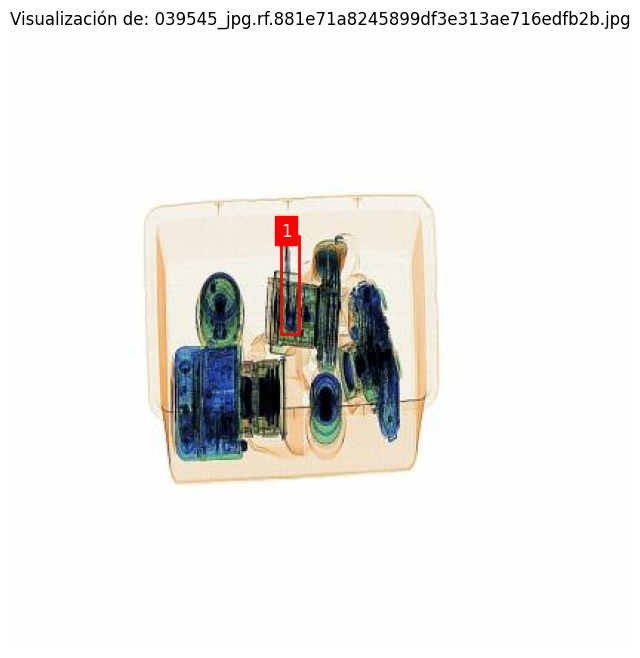

In [139]:
image_files = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
random_image = random.choice(image_files)
visualize_image_with_bboxes(train_images_dir, train_labels_dir, random_image, class_names)

### 2. Análisis de Bounding Boxes

In [140]:
def get_all_bboxes(label_dir):
    """
    Recorre todos los archivos de etiquetas y extrae la información de las bounding boxes.
    """
    bboxes = []
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    parts = list(map(float, line.split()))
                    bboxes.append(parts)
    return np.array(bboxes)

In [141]:
all_train_bboxes = get_all_bboxes(train_labels_dir)
print(f"Total de Bounding Boxes en el set de entrenamiento: {len(all_train_bboxes)}")

classes = all_train_bboxes[:, 0].astype(int)
centers_x = all_train_bboxes[:, 1]
centers_y = all_train_bboxes[:, 2]
widths = all_train_bboxes[:, 3]
heights = all_train_bboxes[:, 4]

Total de Bounding Boxes en el set de entrenamiento: 6181


#### 2.1. Distribución de Tamaños (Área)

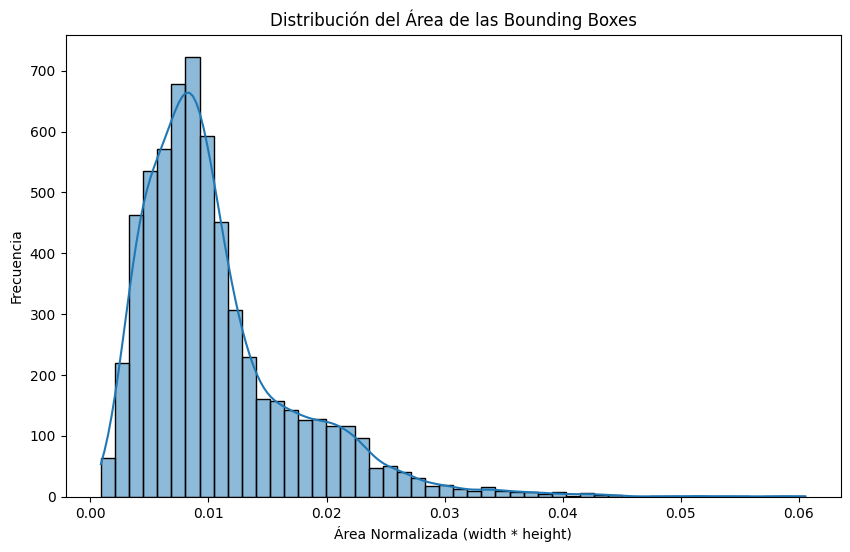

In [142]:
areas = widths * heights
plt.figure(figsize=(10, 6))
sns.histplot(areas, bins=50, kde=True)
plt.title('Distribución del Área de las Bounding Boxes')
plt.xlabel('Área Normalizada (width * height)')
plt.ylabel('Frecuencia')
plt.show()

Lo primero que salta a la vista es que casi todos los objetos que tenemos que encontrar son bastante chicos. Si vemos el gráfico, la mayoría de las cajitas tienen un área bastante pequeña, menos de 0.2. Hay algunos objetos grandes, pero son pocos.

#### 2.2. Distribución de Aspect Ratios

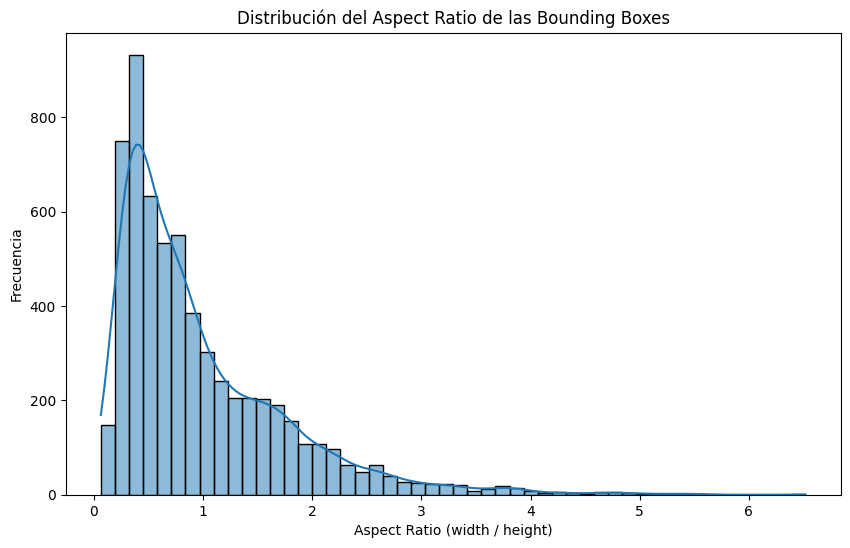

In [143]:
aspect_ratios = widths / heights
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=50, kde=True)
plt.title('Distribución del Aspect Ratio de las Bounding Boxes')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frecuencia')
plt.show()

Acá se ve que los objetos no tienen una única forma. Hay un montón que son más o menos cuadrados (el pico en 1.0), pero también hay bastantes que son más altos que anchos, o más anchos que bajos.

#### 2.3. Mapa de Calor de Ubicaciones

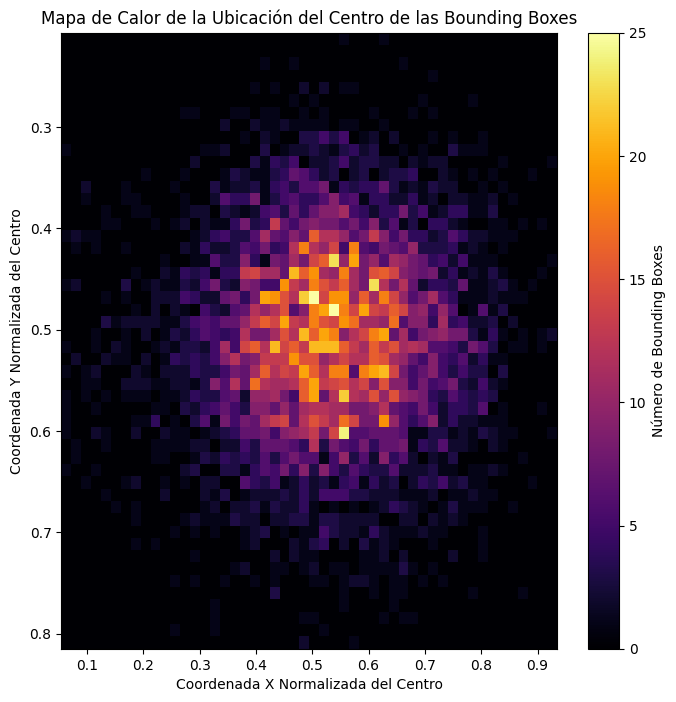

In [144]:
plt.figure(figsize=(8, 8))
plt.hist2d(centers_x, centers_y, bins=50, cmap='inferno')
plt.colorbar(label='Número de Bounding Boxes')
plt.title('Mapa de Calor de la Ubicación del Centro de las Bounding Boxes')
plt.xlabel('Coordenada X Normalizada del Centro')
plt.ylabel('Coordenada Y Normalizada del Centro')
plt.gca().invert_yaxis()

Este gráfico es el más claro de todos. Casi todos los objetos aparecen en el centro de la imagen. A medida que te vas a los bordes, no hay casi nada. Tiene lógica, porque las cosas pasan por el medio del escáner.

### 3. Data Augmentation para Balanceo de Clases

In [145]:
def plot_class_distribution(label_dirs, title, class_names_map):
    """
    Calcula y grafica la distribución de clases a partir de directorios de etiquetas.
    """
    all_classes = []
    if not isinstance(label_dirs, list):
        label_dirs = [label_dirs]
        
    for label_dir in label_dirs:
        if not os.path.isdir(label_dir):
            print(f"Advertencia: El directorio {label_dir} no existe. Será omitido.")
            continue
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                with open(os.path.join(label_dir, label_file), 'r') as f:
                    for line in f:
                        class_id = int(float(line.split()[0]))
                        all_classes.append(class_id)
    
    # ocurrencias de cada clase
    class_counts = Counter(all_classes)
    
    class_indices = sorted(class_counts.keys())
    counts = [class_counts[i] for i in class_indices]
    class_labels = [class_names_map[i] for i in class_indices]

    plt.figure(figsize=(12, 7))
    sns.barplot(x=class_labels, y=counts, hue=class_labels, palette='viridis', legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Clase', fontsize=12)
    plt.ylabel('Número de Instancias', fontsize=12)
    plt.xticks(rotation=45)
    
    for index, value in enumerate(counts):
        plt.text(index, value + 0.5, str(value), ha='center')
        
    plt.tight_layout()
    plt.show()

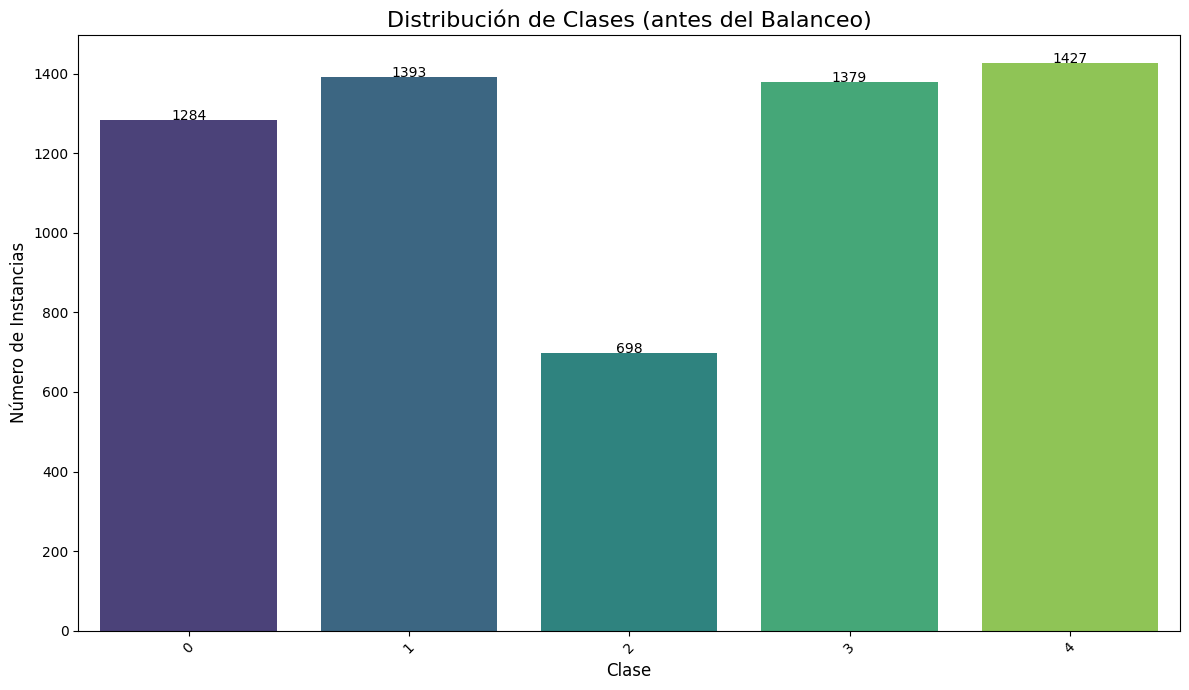

In [146]:
plot_class_distribution([train_labels_dir], 'Distribución de Clases (antes del Balanceo)', class_names)

#### 3.1 Calcular la distribución inicial y definir el objetivo

In [147]:
initial_class_counts = Counter()
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(float(line.split()[0]))
                    initial_class_counts[class_id] += 1

other_class_counts = [count for class_id, count in initial_class_counts.items() if class_id != 2]
target_count = int(np.mean(other_class_counts)) if other_class_counts else 0

initial_count_class_2 = initial_class_counts.get(2, 0)

print(f"Distribución inicial: {sorted(initial_class_counts.items())}")
print(f"Instancias iniciales de la clase '2': {initial_count_class_2}")
print(f"Objetivo de instancias (promedio de las otras clases): {target_count}")

Distribución inicial: [(0, 1284), (1, 1393), (2, 698), (3, 1379), (4, 1427)]
Instancias iniciales de la clase '2': 698
Objetivo de instancias (promedio de las otras clases): 1370


In [148]:
aug_images_dir = os.path.join(os.path.dirname(train_images_dir), 'augmented_images')
aug_labels_dir = os.path.join(os.path.dirname(train_labels_dir), 'augmented_labels')

if os.path.exists(aug_images_dir):
    shutil.rmtree(aug_images_dir)
if os.path.exists(aug_labels_dir):
    shutil.rmtree(aug_labels_dir)
os.makedirs(aug_images_dir, exist_ok=True)
os.makedirs(aug_labels_dir, exist_ok=True)

print(f"\nDirectorios de aumentación limpios en: {aug_images_dir}")


Directorios de aumentación limpios en: dataset\train\augmented_images


In [149]:
class_2_images = []
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip() and line.startswith('2 '):
                    class_2_images.append(label_file.replace('.txt', '.jpg'))
                    break

print(f"Se encontraron {len(class_2_images)} imágenes con la clase '2'.")

Se encontraron 698 imágenes con la clase '2'.


In [150]:
if initial_count_class_2 > 0 and initial_count_class_2 < target_count:
    num_augmentations = math.ceil((target_count / initial_count_class_2) - 1)
    num_augmentations = max(1, num_augmentations)
else:
    num_augmentations = 0

print(f"Se generarán {num_augmentations} aumentos por cada imagen de la clase '2'.")

Se generarán 1 aumentos por cada imagen de la clase '2'.


#### 3.2. Definir la pipeline de aumentación

In [151]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=25, p=0.6, border_mode=cv2.BORDER_CONSTANT),
    A.Blur(blur_limit=3, p=0.2),
    A.GaussNoise(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

#### 3.3. Función para generar y guardar imágenes aumentadas

In [152]:
def augment_and_save(image_path, label_path, output_img_dir, output_lbl_dir, transform, num_augmentations):
    """
    Aplica transformaciones a una imagen y su etiqueta, y guarda los resultados.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.split())
            bboxes.append([x, y, w, h])
            class_labels.append(int(class_id))
    
    for i in range(num_augmentations):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        new_img_name = f"{base_name}_aug_{i}.jpg"
        new_lbl_name = f"{base_name}_aug_{i}.txt"
        
        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_img_dir, new_img_name), aug_image_bgr)
        
        with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
            for bbox, class_id in zip(aug_bboxes, augmented['class_labels']):
                x, y, w, h = bbox
                f.write(f"{class_id} {x} {y} {w} {h}\n")

#### 3.4. Aplicar aumentación

In [153]:
if num_augmentations > 0:
    for image_name in class_2_images:
        img_path = os.path.join(train_images_dir, image_name)
        lbl_path = os.path.join(train_labels_dir, image_name.replace('.jpg', '.txt'))
        
        if os.path.exists(img_path):
            augment_and_save(img_path, lbl_path, aug_images_dir, aug_labels_dir, transform, num_augmentations)

    print("\n¡Proceso de aumentación de datos para la clase '2' completado!")
else:
    print("\nNo fue necesario realizar aumentación de datos para la clase '2'.")


¡Proceso de aumentación de datos para la clase '2' completado!


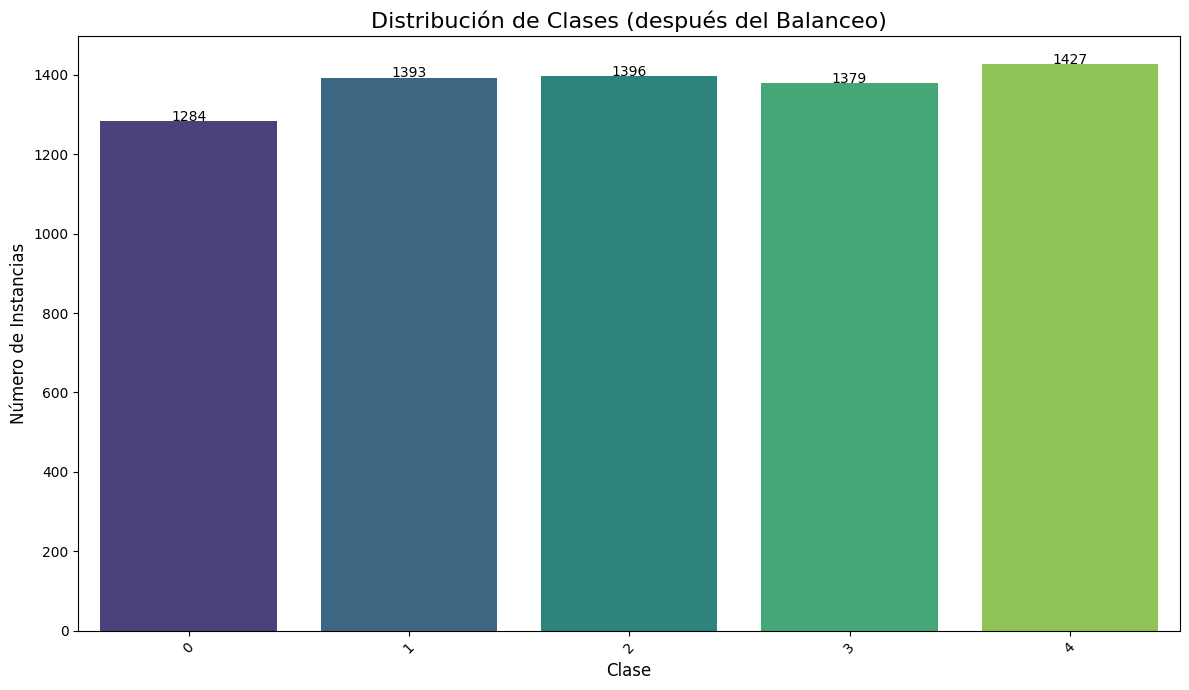

In [154]:
plot_class_distribution([train_labels_dir, aug_labels_dir], 'Distribución de Clases (después del Balanceo)', class_names)

## Segunda entrega: 

### Modelo 1:

### Modelo 2:

### Modelo 3: Implementación de CornerNet